# Practica Tema 5: Construcción de un flujo de trabajo para problemas de clasificación

Para la siguiente práctica vas a aplicar todos los conceptos y el código que revisaste en el tema 5. Vas a trabajar con el código y los datos del Call Center.

## Pregunta

El flujo de trabajo que hemos revisado hasta este momento nos ha permitido optimizar y evaluar un xgboost para clasificar a los clientes de un banco en quiénes sí aceptarían un depósito a plazo y quiénes no. Utiliza Google Colab y repite el mismo flujo de trabajo para optimizar y evaluar un xgboost.

In [ ]:
# Instalar versiones de pandas y yellowbrick
# Instalar última versión de yellowbrick y sklearn
!pip install yellowbrick==1.3.post1
!pip install scikit-learn==0.24.2
!pip install dtreeviz==1.3.1

### Cargar datos y preprocesar datos crudos

In [1]:
%matplotlib inline

# importar librerías estándar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import * 

In [2]:
# Cargar funciones de preprocesamiento
def fun_preprocess_numeric_variables(df):
    '''Regresa un data frame con las variables numéricas preprocesadas.
    
    Codificar mes como una variable numéricas
    Seleccionar el resto de las varaibles numéricas.
    
    Parameters
    ----------
    df: DataFrame
        DataFrame con los datos del banco.
        
    Returns
    -------
    DataFrame
        DataFrame con los campos numéricos preprocesados . 
    '''
 
    month_enc = {
        'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 
        'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12
    }
    df_month = df.month.map(month_enc).to_frame()
    df_numeric = df[['day', 'duration', 'campaign', 'pdays', 'previous']]
    
    return pd.concat([df_month, df_numeric], axis = 1)

def fun_preprocess_categorical_variables(df):
    '''Regresar un data frame con las variables categóricas preprocesadas.

    Convierte en dummies las variables categóricas (loan, housing, marital contact, 
    unknown, other, education y job). 
    En algunos casos recodifica algunas categorías con replace.
    Para una variable categórica se elimina la primera opción con drop_first
    esto es para evitar problemas de multicolinealidad en algunos algorítmos.
    
    Parameters
    ----------
    df: DataFrame
        DataFrame con los datos del banco.
        
    Returns
    -------
    DataFrame
        DataFrame con los campos categóricos preprocesados.  
    '''
    
    df_loans = pd.get_dummies(df[['loan', 'housing', 'default']], drop_first = True)
    df_marital = pd.get_dummies(df[['marital']], drop_first = True)
    df_contact = pd.get_dummies(df[['contact']], drop_first = True)
    df_outcome = pd.get_dummies(
        df.poutcome.replace({'unknown':'other'}), 
        drop_first=True, 
        prefix = 'poutcome'
    )
    df_education = pd.get_dummies(
        df.education.replace(
            {'primary':'not undergraduate', 'secondary':'not undergraduate', 
             'unknown':'not undergraduate', 'tertiary':'undergraduate'}), 
        prefix = 'education', 
        drop_first=True
    )
    df_job = pd.get_dummies(
        df.job.replace(
            {'unknown':'other', 'unemployed':'other', 'housemaid':'other', 
             'entrepreneur':'other', 'student':'other', 'self-employed':'other'}), 
        prefix = 'job', 
        drop_first=True
    ) 
    return pd.concat([df_loans, df_marital, df_contact, df_outcome, df_education, df_job], axis = 1)

def fun_preprocesar_atributos(df):
    '''Regresa un DataFrame con los datos numéricos y categóricos preprocesados
    
    Parameters
    ----------
    df: DataFrame
        DataFrame con los datos del banco.
        
    Returns
    -------
    DataFrame
        DataFrame con los datos preprocesados
    '''
    df_numeric = fun_preprocess_numeric_variables(df) 
    df_categorical = fun_preprocess_categorical_variables(df)
    
    return pd.concat([df_numeric, df_categorical], axis = 1)

def fun_preprocesar_categoria(df):
    '''Regresa un numpy array con la variable dependiente
    
    Toma los datos del banco, extrae la variable dependiente,
    la convierte en una variable de dummy donde:
        1 = el cliente sí aceptó el depósito a plazo
        0 = el cliente no aceptó el depósito a plazo
        
    Asimismo, se convierten los datos a int64 y se formata el
    array para que tenga la siguiente dimensión (n, )
    
    
    Parameters
    ----------
    df: DataFrame
        DataFrame con los datos del banco.
        
    Returns
    -------
    ndarray
        Regresa un numpy array con dimensión (n, ) con la variable
        dependiente que toma valores de 1 y 0.
    '''
    
    return pd.get_dummies(df.y, drop_first=True).astype('int64').values.ravel()



In [3]:
# Cargar los datos
test_set = pd.read_csv("data/test.csv", sep=";")
train_full = pd.read_csv("data/train.csv", sep=";")

In [4]:
# Construir los conjuntos de entrenamiento y validación
from sklearn.model_selection import train_test_split
train_set, validation_set = train_test_split(
    train_full,
    test_size = test_set.shape[0],
    stratify=train_full.y,
    shuffle=True
)

In [5]:
# Preprocesar los conjuntos
X_train = fun_preprocesar_atributos(train_set)
y_train = fun_preprocesar_categoria(train_set)

X_val = fun_preprocesar_atributos(validation_set)
y_val = fun_preprocesar_categoria(validation_set)

### Ajustar modelo

**TODO**

* Construye un xgboost.
* Explora los hiperparámetros utilizando RandomSearch.
* Recupera el mejor modelo.

In [6]:
# Construye y ajusta un xgboost utilizando random search
import xgboost as xgb
# Especificamos el modelo 
# (Ojo, este algorítmo usa otros nombres para los parámetros)
clf_xgb = xgb.XGBClassifier(
    objective='binary:logistic',		# Para un problema de clasificación binaria
    eval_metric='auc',					# Métrica de evaluación
    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    									# scale_pos_weight es el parámetro para 
    									# reponderar las categorías con desbalance.
    use_label_encoder=False,			# Hay que indicar esta opción
    random_state=42					# Fijar semilla para reproducibilidad
)



In [7]:
# Especifica los parámetros a explorar. 
# Tal vez necesitas revisar la documentación de xgboost para 
# comprender como funcionan los hiperparámetros.
# https://xgboost.readthedocs.io/en/latest/parameter.html

from sklearn.model_selection import RandomizedSearchCV

params = {
    'n_estimators':[150],
    'learning_rate':[.01],
    'max_depth':[10],
    'subsample':[0.75],
    'colsample_bytree':[0.75],
    'colsample_bylevel':[0.75],
    'reg_lambda':[0.01]
}

grid_search = RandomizedSearchCV(
	clf_xgb,					# Especificar el modelo (estimador) 
	params,						# Especificar los parámetros de la malla 
	scoring = 'roc_auc', 		# Especificar la métrica de evaluación
	cv = 10,					# Especificar los k-cortes de la validación cruzada 
	n_iter=100,					# Especificar número de modelos a explorar aleatoriamente 
    return_train_score=True,# Agregar el error de entrenamiento
	n_jobs=-1					# Especificar el número de CPUs para paralelizar el trabajo
    							# -1= todos los disponibles
)
# Entrenar los modelos
grid_search.fit(X_train, y_train)

/Users/dantegruizmartinez/.pyenv/versions/3.8.0/envs/diplomado/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.


RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           eval_metric='auc', gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=Non...
                                           scale_pos_weight=7.548319327731092,
                                           subsample=None, tree_method=None,
                         

In [8]:
# Carga las funciones para imprimir los resultados del random search
def fun_plot_grid_search_results(df):   
    '''Regresa un DataFrame con los resultados de la exploración de hiperparámetros.

    Esta función muestra una tabla estilizada con los resultados de la exploración de
    hiper parámetros utilizando validación cruzada.
    
    En la tabla aparecen del lado izquierdo la combinación de hiperparámetros, el error
    de entrenamiento y el error de validación cruzada y el ranking del mejor modelo
    a partir del error de validación.
    
    El mapa de color va de azul (modelos con menor error) a rojo (modelos con mayor error).
    Se calcula para el error de entrenamiento y validación de manera separada.
    
    Los resultados están ordenados de mejor a peor modelo, en función del error de validación.
    
    Parameters
    ----------
    dict: Diccionario con los resultados de la búsqueda de hiperparámetros GridSearchCV.cv_results_ 
        
    Returns
    -------
    pandas.io.formats.style.Styler
        Regresa una tabla estilizada con los resultados de la búsqueda de hiperparámetros.
    '''
    # Elegir paleta divergente de colores
    cm = sns.diverging_palette(5, 250, as_cmap=True)
    
    return (
        pd.concat([
            # Limpiar la columna de parámetros
            df['params'].apply(pd.Series), 
            # Extraer solamente el error de prueba 
            df[['mean_train_score', 'mean_test_score', 'rank_test_score']]],
            axis = 1
        )
        # Ordenar los modelos de mejor a peor
        .sort_values(by = 'rank_test_score')
        # Pintar el fondo de la celda a partir del error de validación
        .style.background_gradient(cmap=cm, subset = ['mean_train_score', 'mean_test_score'])
    )

def fun_resumen_grid_search(grid_search):
    '''Imprime un resumen del grid search.
    
    Imprime el número de modelos que se entrenaron y 
    devuelve los hiperparámetros del mejor modelo.
    
    Parameters
    ----------
    grid_search (GridSearchCV): Fitted GridSearch con los resultados.
    '''
    best_params = grid_search.best_params_
    print("\nSe evaluaron {} modelos utilizando el grid search.".format(pd.DataFrame(grid_search.cv_results_).shape[0]))
    print("\nLos hiperparámetros del mejor modelo son: " + str(best_params) + "\n")

In [9]:
# Recupearar los resultados de la validación cruzada
df_best_params = pd.DataFrame(grid_search.cv_results_)
tabla_resultados = fun_plot_grid_search_results(df_best_params)
tabla_resultados

,subsample,reg_lambda,n_estimators,max_depth,learning_rate,colsample_bytree,colsample_bylevel,mean_train_score,mean_test_score,rank_test_score
0,0.750000,0.010000,150.000000,10.000000,0.010000,0.750000,0.750000,0.971663,0.929635,1


In [10]:
# Recuepar los resultados de la validación cruzada.
fun_resumen_grid_search(grid_search)


Se evaluaron 1 modelos utilizando el grid search.

Los hiperparámetros del mejor modelo son: {'subsample': 0.75, 'reg_lambda': 0.01, 'n_estimators': 150, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'colsample_bylevel': 0.75}



In [11]:
# Recuperar el estimador del mejor modelo.
best_model_xgb = grid_search.best_estimator_

### Evaluación

**TODO**
* Construye una matriz de confusión.
* Construye un reporte de clasificación.
* Construye una curva de precision-recall
* Construye una curva ROC
* Calcula el ROC-AUC score
* Construye una curva de discriminación del punto de corte.
* Ajustarías el punto de corte, evalúa.

In [12]:
# Cargar funciones especiales para evaluar los modelos de clasificación.
from yellowbrick.classifier.threshold import DiscriminationThreshold
from yellowbrick.classifier import (
    ConfusionMatrix, ClassPredictionError, ClassificationReport,
    PrecisionRecallCurve, ROCAUC, ClassPredictionError
)
from yellowbrick.model_selection import FeatureImportances
from sklearn.metrics import roc_auc_score

def fun_graficar_matriz_confusion(model, X_val_test, y_val_test):
    '''Graficar matriz de confusión
    
    Parameters
    ----------
    model (Estimator): Fitted estimator
    X_test (DataFrame): Predictores del conjunto de validación o prueba.
    y_test (ndarray): Clases del conjunto de validación o prueba.
    ''' 
    fig, ax = plt.subplots(figsize = (5,5))
    cm = ConfusionMatrix(
        model,
        classes=['no', 'yes']
    )
    cm.fit(X_train, y_train)
    cm.score(X_val_test, y_val_test)
    cm.show();
    
def fun_graficar_reporte_clasificacion(model, X_val_test, y_val_test):
    '''Graficar reporte de clasificación
    
    Parameters
    ----------
    model (Estimator): Fitted estimator
    X_test (DataFrame): Predictores del conjunto de validación o prueba.
    y_test (ndarray): Clases del conjunto de validación o prueba.
    '''   
    fig, ax = plt.subplots(figsize = (6,5))
    visualizer = ClassificationReport(
        model,
        classes=['no', 'yes']
    )
    visualizer.fit(X_train, y_train)
    visualizer.score(X_val_test, y_val_test)
    visualizer.show();  
    
def fun_graficar_curva_precision_recall(model, X_val_test, y_val_test):
    '''Graficar curva de precision y recall
    
    Parameters
    ----------
    model (Estimator): Fitted estimator
    X_test (DataFrame): Predictores del conjunto de validación o prueba.
    y_test (ndarray): Clases del conjunto de validación o prueba.
    '''
    fig, ax = plt.subplots(figsize = (6,6))
    viz = PrecisionRecallCurve(model)
    viz.fit(X_train, y_train)
    viz.score(X_val_test, y_val_test)
    viz.show();
    
def fun_graficar_curva_roc(model, X_val_test, y_val_test):
    '''Graficar curva ROC
    
    Parameters
    ----------
    model (Estimator): Fitted estimator
    X_test (DataFrame): Predictores del conjunto de validación o prueba.
    y_test (ndarray): Clases del conjunto de validación o prueba.
    '''
    fig, ax = plt.subplots(figsize = (6,6))
    roc_curves_visualizer = ROCAUC(
        model,
        classes=['no', 'yes']
    )
    roc_curves_visualizer.fit(X_train, y_train)
    roc_curves_visualizer.score(X_val, y_val) 
    roc_curves_visualizer.show();
    
def fun_imprimir_roc_auc_score(model, X_val_test, y_val_test):
    '''Imprime el ROC AUC score
    
    Parameters
    ----------
    model (Estimator): Fitted estimator de un DecisionTree, Random Forest o xgboost.
    X_val_test (DataFrame): Clases actuales
    y_val_test (ndarray): Probabildades de clase
    '''
    print(
        "roc_auc_score: {}".format(
            np.round(roc_auc_score(y_val_test, model.predict_proba(X_val_test)[:,1]), 3)
        )
    )
    
def fun_graficar_error_clasificacion(model, X_val_test, y_val_test):
    '''Graficar error de clasificación
    
    Parameters
    ----------
    model (Estimator): Fitted estimator
    X_test (DataFrame): Predictores del conjunto de validación o prueba.
    y_test (ndarray): Clases del conjunto de validación o prueba.
    '''
    fig, ax = plt.subplots(figsize = (7,6))
    cpe_viz = ClassPredictionError(model, classes = ['no', 'yes'])
    cpe_viz.fit(X_train, y_train)
    cpe_viz.score(X_val_test, y_val_test)
    cpe_viz.show();

def fun_graficar_importancias(model):
    '''Graficar importancia de características
    
    Parameters
    ----------
    model (Estimator): Fitted estimator de un DecisionTree, Random Forest o xgboost.
    '''
    fig, ax = plt.subplots(figsize = (8,6))
    viz = FeatureImportances(model)
    viz.fit(X_train, y_train)
    viz.show();
    
def fun_graficar_discrimination_threshold(model, X_val_test, y_val_test):
    '''Graficar relación de precision y recall con distintos puntos de corte
    
    Parameters
    ----------
    model (Estimator): Fitted estimator de un DecisionTree, Random Forest o xgboost.
    X_val_test (DataFrame): Clases actuales
    y_val_test (ndarray): Probabildades de clase
    '''
    fig, ax = plt.subplots(figsize = (8,6))
    visualizer = DiscriminationThreshold(
        model,
        exclude = ["queue_rate"]
    )
    visualizer.fit(X_val_test, y_val_test)
    visualizer.show();     

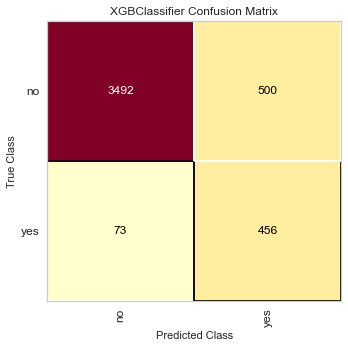

In [13]:
# Graficar matriz de confusión
fun_graficar_matriz_confusion(best_model_xgb, X_val, y_val)

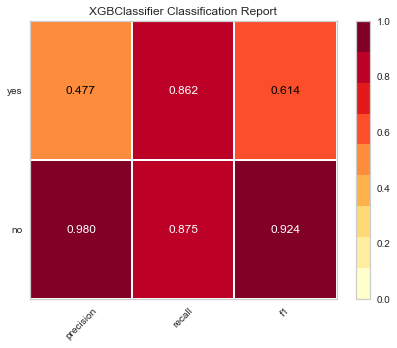

In [14]:
# Graficar reporte de clasificación
fun_graficar_reporte_clasificacion(best_model_xgb, X_val, y_val)

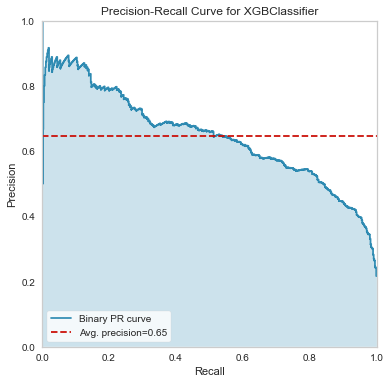

In [15]:
# Graficar curva de precision y recall
fun_graficar_curva_precision_recall(best_model_xgb, X_val, y_val)

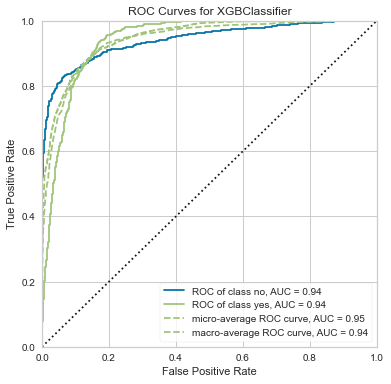

In [16]:
# Graficar curva ROC AUC
fun_graficar_curva_roc(best_model_xgb, X_val, y_val)

In [17]:
# Imprimir el ROC AUC score
fun_imprimir_roc_auc_score(best_model_xgb, X_val, y_val)

roc_auc_score: 0.941


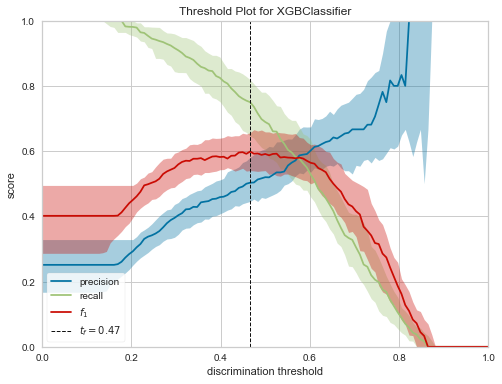

In [18]:
# Graficar curva de discriminación del punto de corte.
fun_graficar_discrimination_threshold(best_model_xgb, X_val, y_val)

In [19]:
# Clasificar con un punto de corte óptimo
def fun_predict_with_threshold(model, threshold = 0.45):
    '''Predice la clase del cliente utilizando un threshold
    
    Permite predecir la clase de un cliente utilizando otros 
    puntos de corte (threshold) que sean diferentes a 0.5.
    
    Parameters
    ----------
    model: Fitted estimator
    threshold (float): Punto de corte entre 0 y 1.
        
    Returns
    -------
    ndarray:
        Regresa un numpy array con el valor de la clase 0 ó 1
    '''
    return np.where( model.predict_proba(X_val)[:,1] < threshold, 0, 1 )


In [20]:
# Calcular clases con un punto de corte en 0.45
y_pred_thr = fun_predict_with_threshold(best_model_xgb, threshold = 0.45)
# Mostrar primeros 20 clientes
y_pred_thr[:20]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

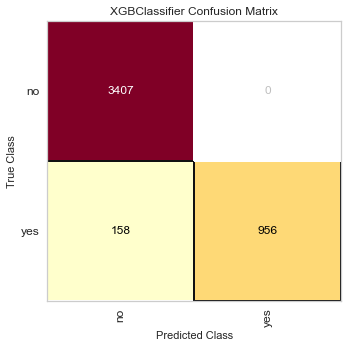

In [21]:
# Graficar matriz de confusión
fun_graficar_matriz_confusion(best_model_xgb, X_val, y_pred_thr)

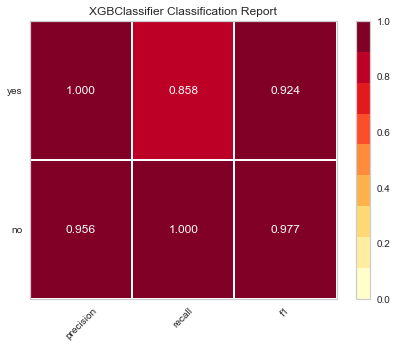

In [22]:
# Graficar reporte de clasificación
fun_graficar_reporte_clasificacion(best_model_xgb, X_val, y_pred_thr)

**TODO**
* Comparando con el árbol de decisión y el xgboost, cómo te fue con este modelo. 
* ¿Cuánto te dio el AUC score? ¿Qué implica esto con respecto a los otros modelos?
* ¿Escogerías un punto de corte diferente? ¿Por qué?